[View in Colaboratory](https://colab.research.google.com/github/wilvega/Tareas_Deep_Learning/blob/master/Colab.ipynb)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1Ys08yalsbM29fvvPhyDxv-SV7TBg3VxK'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [0]:
!unzip cnn_data.zip > /dev/null

In [7]:
!ls

cnn_data.zip  data  datalab  __MACOSX


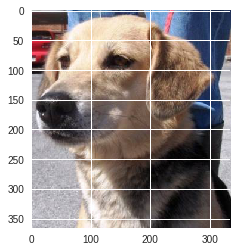

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('data/train/dog/dog.125.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

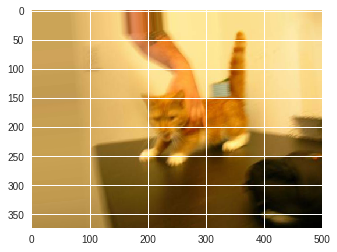

In [9]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
plt.imshow(batch[0]/255) 

Conv Net for Dog-Cat discrimination
Training variables

In [0]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
#epochs = 10
batch_size = 16

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [14]:
epochs = 10
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
125/125 [==============================] - 21s 169ms/step - loss: 0.7032 - acc: 0.4910 - val_loss: 0.6909 - val_acc: 0.5900
Epoch 2/10
125/125 [==============================] - 20s 158ms/step - loss: 0.6884 - acc: 0.5765 - val_loss: 1.1308 - val_acc: 0.5000
Epoch 3/10
125/125 [==============================] - 20s 158ms/step - loss: 0.6661 - acc: 0.6185 - val_loss: 0.6340 - val_acc: 0.6550
Epoch 4/10
 42/125 [=========>....................] - ETA: 10s - loss: 0.6747 - acc: 0.6176

125/125 [==============================] - 20s 158ms/step - loss: 0.6443 - acc: 0.6525 - val_loss: 0.6167 - val_acc: 0.6700
Epoch 5/10
125/125 [==============================] - 20s 156ms/step - loss: 0.6307 - acc: 0.6540 - val_loss: 0.5990 - val_acc: 0.7000
Epoch 6/10
125/125 [==============================] - 19s 156ms/step - loss: 0.5975 - acc: 0.6895 - val_loss: 0.7545 - val_acc: 0.6125
Epoch 7/10
 57/125 [============>.................] - ETA: 8s - loss: 0.5850 - acc: 0.7072

125/125 [==============================] - 20s 158ms/step - loss: 0.5921 - acc: 0.6980 - val_loss: 0.5440 - val_acc: 0.7175
Epoch 8/10
125/125 [==============================] - 20s 159ms/step - loss: 0.5596 - acc: 0.7255 - val_loss: 0.5267 - val_acc: 0.7175
Epoch 9/10
125/125 [==============================] - 20s 160ms/step - loss: 0.5400 - acc: 0.7410 - val_loss: 0.5725 - val_acc: 0.6750
Epoch 10/10
 59/125 [=============>................] - ETA: 8s - loss: 0.5500 - acc: 0.7383

125/125 [==============================] - 20s 157ms/step - loss: 0.5338 - acc: 0.7430 - val_loss: 0.5287 - val_acc: 0.7250


In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13148680982817639190
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285974221
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7549473229551240595
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


**Testing the classifier**
We will use the validation generator to generate one batch of samples and we'll pass them to the model

[1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.]
[[0.84451574]
 [0.9961696 ]
 [0.60442895]
 [0.83195996]
 [0.23127192]
 [0.30852184]
 [0.72248334]
 [0.43201655]
 [0.64387435]
 [0.5477566 ]
 [0.19208206]
 [0.36858535]
 [0.34462047]
 [0.21593116]
 [0.50593024]
 [0.27892464]]


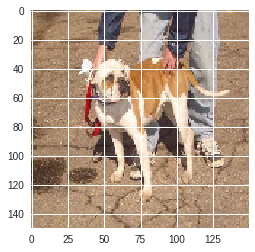

In [16]:
for x_batch, y_batch in validation_generator:
  plt.imshow(x_batch[0])
  print(y_batch)
  print(model.predict_proba(x_batch))
  break